In [2]:
!pip install numpyro

import pytensor.tensor as pt
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc.sampling_jax
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import mean_squared_error
import xarray as xr
import numpyro
from datetime import date

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100

%load_ext rich
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Data Preparation

In [3]:
data = pd.read_csv('MMM_test_data.csv')
data["start_of_week"] = pd.to_datetime(data['start_of_week'], format='%d-%m-%y')
data.head()


start_of_week    revenue  spend_channel_1  spend_channel_2  spend_channel_3  \
0    2020-08-30  157906.75          2625.48           262.71         12954.12   
1    2020-09-06  186425.68          2634.01           108.66          8760.28   
2    2020-09-13  161607.39          2087.08           110.32          7155.42   
3    2020-09-20  180089.13          1690.70            52.79         15185.22   
4    2020-09-27  217793.98          1547.30            80.56         18524.05   

   spend_channel_4  spend_channel_5  spend_channel_6  spend_channel_7  
0          3609.63         12955.29         12659.12         19379.79  
1          4560.60         12747.70         12338.18         22473.45  
2          4362.96         15015.41         10811.15         22596.05  
3          3883.41         15521.41         12890.22         24728.73  
4          4043.09         15793.74         12642.55         26515.48


## Convert date to day_of_year

In [5]:


def convert_to_day_of_year(df, date_column):
  """
  This function applies day of year conversion to a column of dates in a pandas DataFrame.

  Args:
      df: The pandas DataFrame containing the date column.
      date_column: The name of the column containing dates in YYYY-MM-DD format.

  Returns:
      A new DataFrame with a new column named 'Day_of_Year' containing the converted values.
  """
  try:
    # Attempt to parse the entire date column
    df['Day_of_Year'] = pd.to_datetime(df[date_column], format='%Y-%m-%d').dt.strftime('%j')
  except ValueError:
    print("Invalid date format in some entries of the column. Filling with NaN.")
    df['Day_of_Year'] = pd.to_datetime(df[date_column], errors='coerce').dt.dayofyear  # Fill with NaN for errors
  return df



In [6]:
df = data.copy()
df.columns
dayofyear = pd.DataFrame(df['start_of_week'])

df['dayofyear']= convert_to_day_of_year(dayofyear, "start_of_week")["Day_of_Year"]
df["dayofyear"] = pd.to_numeric(df['dayofyear'], errors='coerce')
df.head()

start_of_week    revenue  spend_channel_1  spend_channel_2  spend_channel_3  \
0    2020-08-30  157906.75          2625.48           262.71         12954.12   
1    2020-09-06  186425.68          2634.01           108.66          8760.28   
2    2020-09-13  161607.39          2087.08           110.32          7155.42   
3    2020-09-20  180089.13          1690.70            52.79         15185.22   
4    2020-09-27  217793.98          1547.30            80.56         18524.05   

   spend_channel_4  spend_channel_5  spend_channel_6  spend_channel_7  \
0          3609.63         12955.29         12659.12         19379.79   
1          4560.60         12747.70         12338.18         22473.45   
2          4362.96         15015.41         10811.15         22596.05   
3          3883.41         15521.41         12890.22         24728.73   
4          4043.09         15793.74         12642.55         26515.48   

   dayofyear  
0        243  
1        250  
2        257  
3        264  
4        271

## Trend

In [7]:
t = (df.index - df.index.min()) / (df.index.max() - df.index.min())


##Seasonality


In [8]:
seasonality = np.sin(2 * np.pi * t / 365) + np.cos(2 * np.pi * t / 365)


## Scaling predictors


In [9]:
t = (df.index - df.index.min()) / (df.index.max() - df.index.min())
channel_columns=['spend_channel_1', 'spend_channel_2', 'spend_channel_3',
       'spend_channel_4', 'spend_channel_5', 'spend_channel_6',
       'spend_channel_7']
# date = df["start_of_week"].to_numpy()
df['start_of_week'] = pd.to_datetime(df['start_of_week'])
date = df['start_of_week'].dt.date
date_index = df.index
y = df["revenue"].to_numpy()
# z = df['spend_channel_1'].to_numpy()#t = t.values

df_transformed = df.copy()
for col in channel_columns:
    df_transformed[col] = df[col].to_numpy()#t = t.values
t = t.values
n_obs = y.size

# Apply MaxAbsScaler transformation
endog_scaler = MaxAbsScaler()
endog_scaler.fit(y.reshape(-1, 1))
y_scaled = endog_scaler.transform(y.reshape(-1, 1)).flatten()

scaler = MaxAbsScaler()
for col in channel_columns:

        df_transformed[col] = scaler.fit_transform(df_transformed[col].values.reshape(-1,1)).flatten()

df_transformed['revenue'] = y_scaled
df_transformed['trend'] = t
df_transformed['seasonality'] = seasonality
df_transformed.head()

start_of_week   revenue  spend_channel_1  spend_channel_2  spend_channel_3  \
0    2020-08-30  0.377599         0.308378         0.163596         0.260702   
1    2020-09-06  0.445796         0.309380         0.067665         0.176301   
2    2020-09-13  0.386448         0.245140         0.068699         0.144003   
3    2020-09-20  0.430643         0.198583         0.032874         0.305603   
4    2020-09-27  0.520806         0.181740         0.050167         0.372797   

   spend_channel_4  spend_channel_5  spend_channel_6  spend_channel_7  \
0         0.159509         0.392470         0.375721         0.250099   
1         0.201532         0.386181         0.366196         0.290023   
2         0.192798         0.454879         0.320874         0.291606   
3         0.171607         0.470208         0.382581         0.319128   
4         0.178663         0.478458         0.375230         0.342186   

   dayofyear     trend  seasonality  
0        243  0.000000     1.000000  
1        250  0.009709     1.000167  
2        257  0.019417     1.000334  
3        264  0.029126     1.000501  
4        271  0.038835     1.000668

## Ploting Chnnels vs revenue

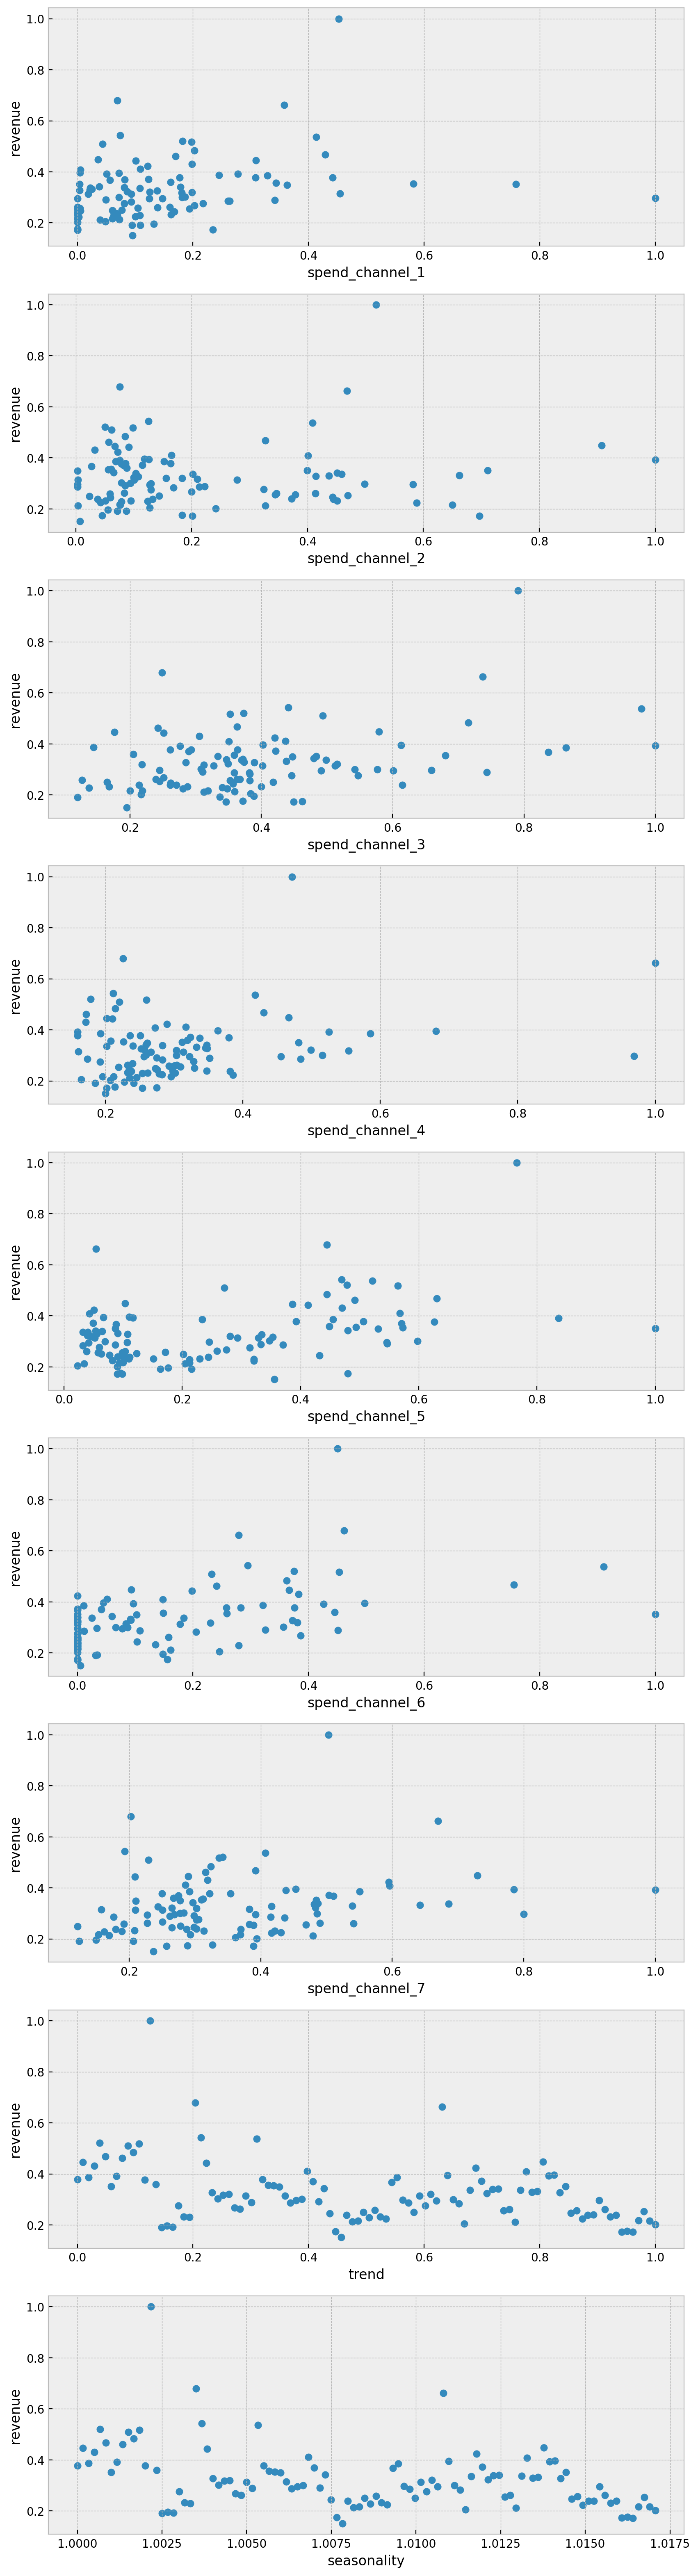

In [180]:
predictor_columns = ['spend_channel_1', 'spend_channel_2',
       'spend_channel_3', 'spend_channel_4', 'spend_channel_5',
       'spend_channel_6', 'spend_channel_7', 'trend',
       'seasonality']

# Create the plot
fig, axes = plt.subplots(len(predictor_columns), figsize=(10, 40))

for i, col in enumerate(predictor_columns):
  # Scatter plot for each predictor vs revenue
  axes[i].scatter(df_transformed[col], df_transformed['revenue'])
  axes[i].set_xlabel(col)
  axes[i].set_ylabel('revenue')


plt.show()

## Matrix of correlation


<Axes: >

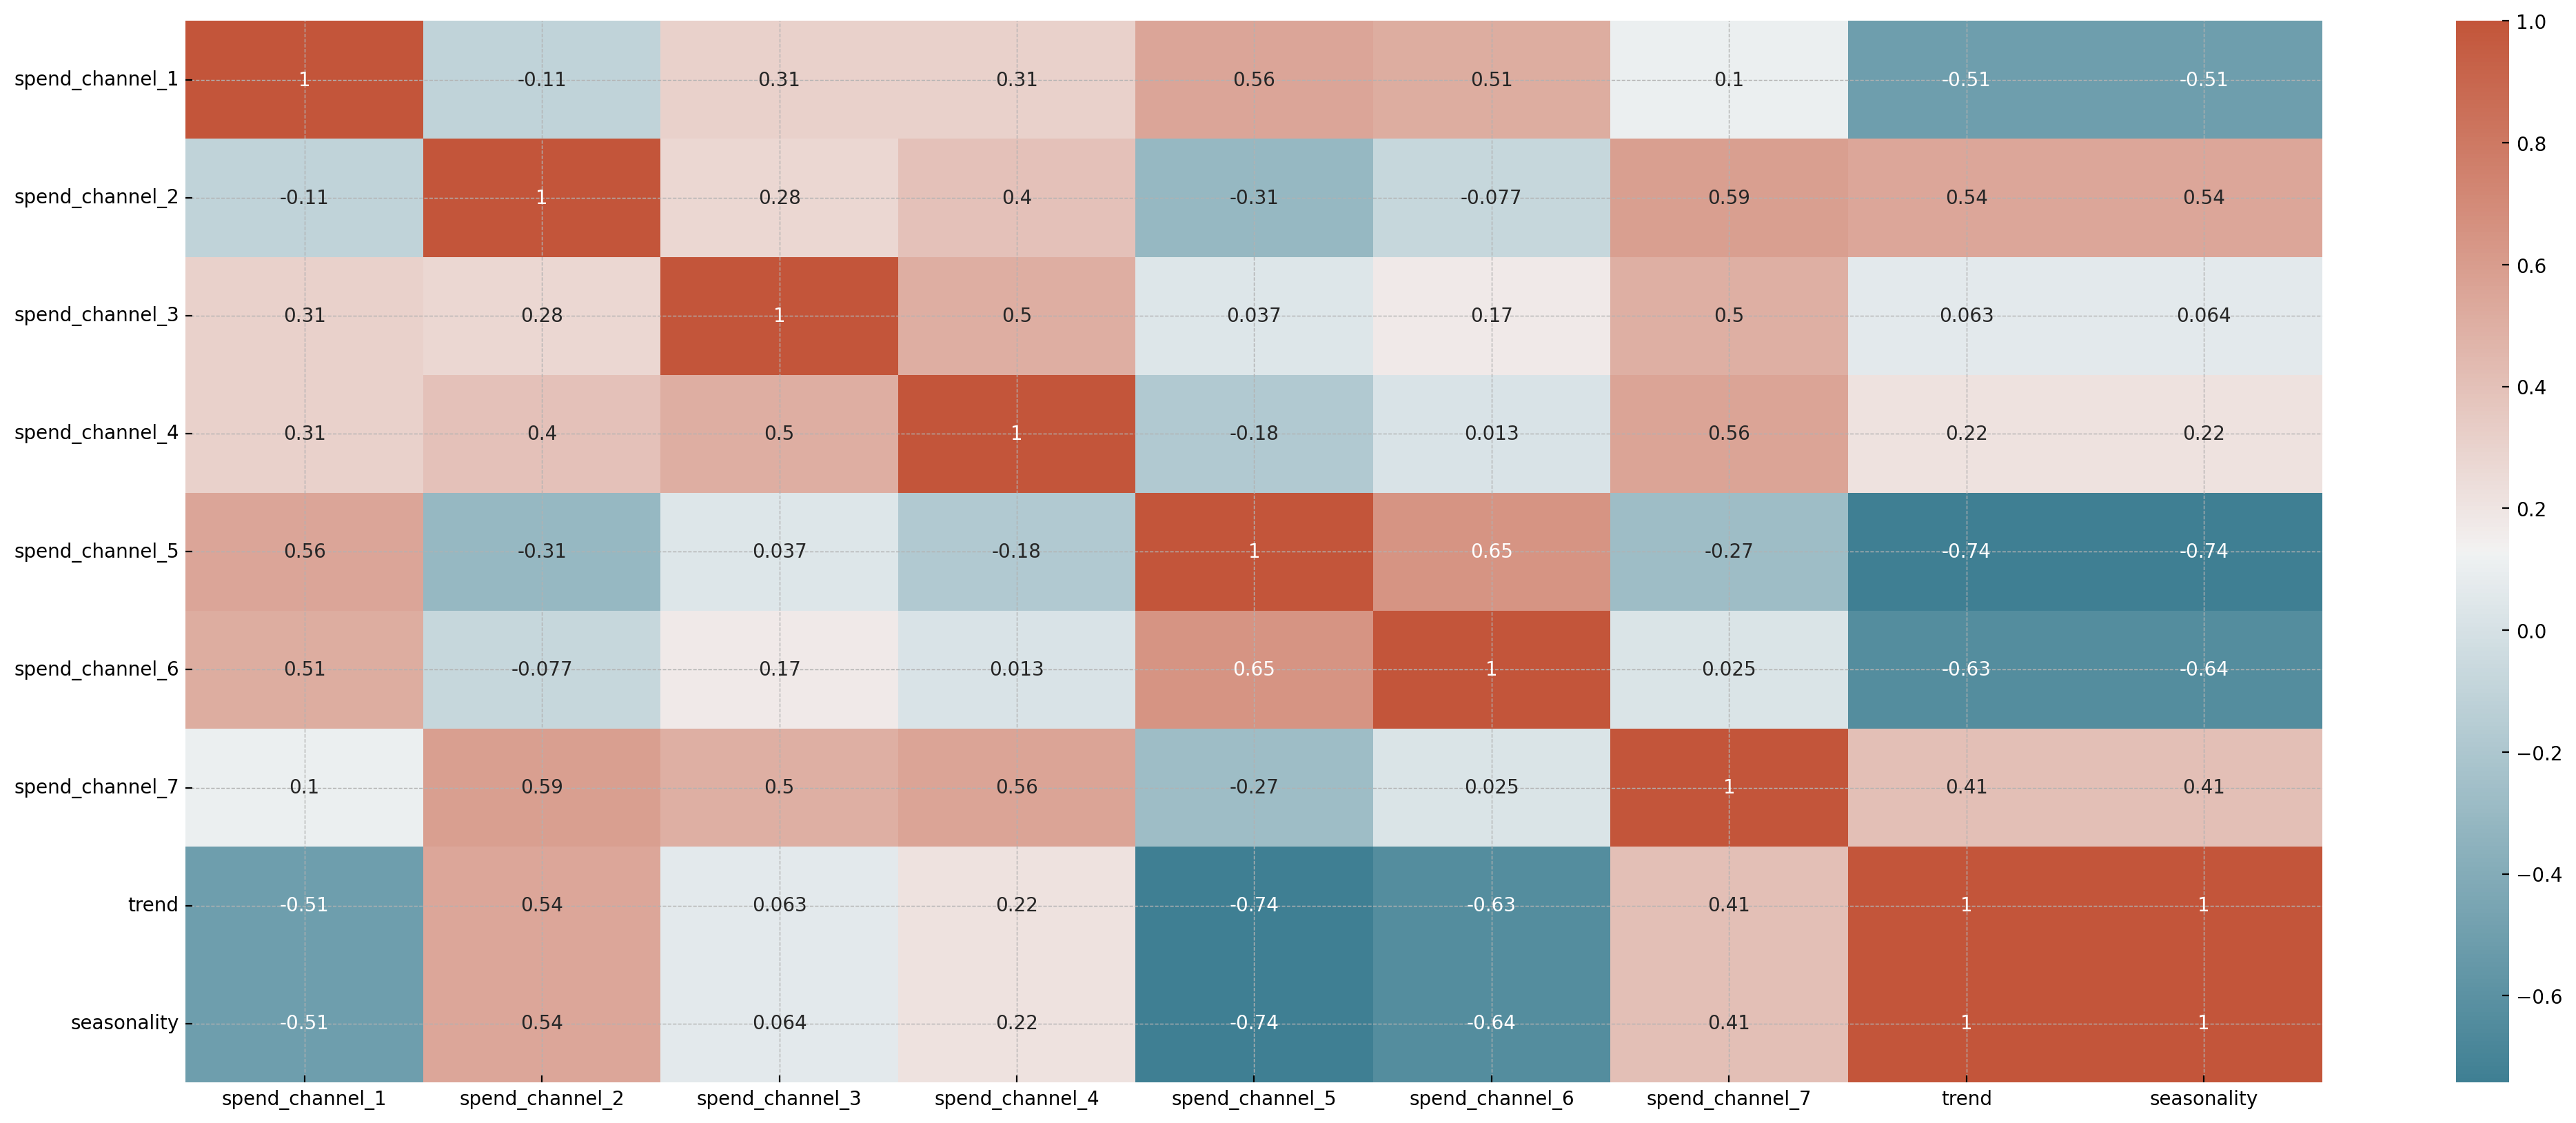

In [10]:
corln = df_transformed[['spend_channel_1', 'spend_channel_2',
       'spend_channel_3', 'spend_channel_4', 'spend_channel_5',
       'spend_channel_6', 'spend_channel_7', 'trend',
       'seasonality']].corr()

fig, ax = plt.subplots(figsize=(25,10))
sns.heatmap(corln, xticklabels = corln.columns, yticklabels = corln.columns, annot = True, cmap = sns.diverging_palette(220, 20, as_cmap=True))

We can see that there high correlation between some channels.

> Add blockquote



### Adstock and shape effect functions


In [11]:
def geometric_adstock(x, alpha: float = 0.0, L: int = 12, normalize = True):
    """Geometric adstock transformation."""

    w = pt.as_tensor_variable([pt.power(alpha, i) for i in range(L)])
    xx = pt.stack([pt.concatenate([pt.zeros(i), x[: x.shape[0] - i]]) for i in range(L)])


    if not normalize:
      y = pt.dot(w, xx)
    else:
      y = pt.dot(w / pt.sum(w), xx)
    return y


    # cycles = [
    #     pt.concatenate(
    #         [pt.zeros(i), x[: x.shape[0] - i]]
    #     )
    #     for i in range(l_max)
    # ]
    # x_cycle = pt.stack(cycles)
    # w = pt.as_tensor_variable([pt.power(alpha, i) for i in range(l_max)])
    # return pt.dot(w, x_cycle)

def geometric_delayed_adstock(x, alpha: float = 0.0, l_max: int = 12, theta: float = 0.0):
    """Geometric delayed adstock transformation."""
    cycles = [
        pt.concatenate(
            [pt.zeros(i), x[: x.shape[0] - i]]
        )
        for i in range(l_max)
    ]
    x_cycle = pt.stack(cycles)
    w = pt.as_tensor_variable([pt.power(alpha, (i - theta)) for i in range(l_max)])
    return pt.dot(w, x_cycle)

def logistic_saturation(x, mu: float = 0.1):
    """Logistic saturation transformation."""
    return (1 - np.exp(-mu * x)) / (1 + np.exp(-mu * x))

## Model

 $y_t= \tau + \sum_{m= 1}^{M}{\beta}_mf(x^{*}_{t,m}) +\sum_{c= 1}^{C}{\beta}_cz_{t,c} +  \varepsilon_t $.

 Where:

 $M$: Number of channels.

 $\beta_m$: coefficient of m-th channel

 $C$: number of control effects. Here, we have two; Trend and seasonality.

 $\beta_c$: coefficient of c-th control effect.

 $\tau$: is intercept.

 $\varepsilon_t $: noise effect


$x^{*}_{t,m}$, the carryover is geometric decay function:

$adstock(x_{t-L+1, m},...,x_{t,m};w_m, L) = \frac{\sum_{l=0}^{L-1}{w_m(l)x_{t-l,m}}}{\sum_{l=0}^{L-1}{w_m(l)}} $.
Here, $w_m(l)$, is delayed adstock function:
$w_m(l;\alpha_m) = \alpha_{m}^{l} $, namely, $\alpha_m$ is the retention rate of ad effect of the m-th media from one period to the next.
And $f$, the shape effect, is the logistic function: $\frac{1 - e^{-\lambda x}}{1 + e^{-\lambda x}}$

I have chosen the prior with some sligh modification inspired by Hellofresh's tutorail and the paper from Bayesian Methods for Media Mix Modeling with Carryover and
Shape E ects 2017 by Yuxue Jin, and other.




Applying carryover (geometric_adstock) and saturation (logistic_saturation):spend_channel_1
Applying carryover (geometric_adstock) and saturation (logistic_saturation):spend_channel_2
Applying carryover (geometric_adstock) and saturation (logistic_saturation):spend_channel_3
Applying carryover (geometric_adstock) and saturation (logistic_saturation):spend_channel_4
Applying carryover (geometric_adstock) and saturation (logistic_saturation):spend_channel_5
Applying carryover (geometric_adstock) and saturation (logistic_saturation):spend_channel_6
Applying carryover (geometric_adstock) and saturation (logistic_saturation):spend_channel_7
Applying controls: trend
Applying controls: seasonality


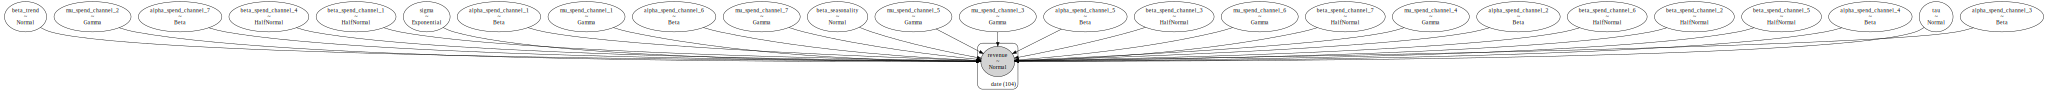

In [12]:
coords = {"date": date}

with pm.Model(coords=coords) as adstock_saturation_model:
# with pm.Model() as adstock_saturation_model:

    response_mean = []

    # --- priors ---
    ## intercept
    intercept = pm.Normal(name="tau", mu=0, sigma=2)

    # ---- Noise -----
    sigma = pm.Exponential('sigma', 10)

    # --- Channels ---
    for channel in channel_columns:
        xx = df_transformed[channel].values


        print(f"Applying carryover (geometric_adstock) and saturation (logistic_saturation):{channel}")
        ## regressor
        channel_b = pm.HalfNormal( name = f"beta_{channel}", sigma = 5)
        ## adstock effect
        alpha = pm.Beta(name= f"alpha_{channel}", alpha=3, beta=3)
        ## saturation effect
        channel_mu = pm.Gamma(name= f"mu_{channel}", alpha=3, beta=1)
        response_mean.append(logistic_saturation(geometric_adstock(xx, alpha), channel_mu) * channel_b)

    # --- Control effects (trend and seasonality) ---
    ## trend
    xx = df_transformed['trend'].values
    print(f"Applying controls: trend")
    control_beta_trend = pm.Normal(name=f"beta_trend", mu=0, sigma=2)
    response_mean.append( xx * control_beta_trend )

    ## seasonality
    xx = df_transformed['seasonality'].values
    print(f"Applying controls: seasonality")
    control_beta_seasonality = pm.Normal(name=f"beta_seasonality", mu=0, sigma=2)
    response_mean.append( xx * control_beta_seasonality )


    # --- likelihood ---
    likelihood = pm.Normal(name="revenue", mu= (intercept+ sum(response_mean)), sigma=sigma, observed= df_transformed['revenue'].values, dims= 'date')


pm.model_to_graphviz(model=adstock_saturation_model)

## Prior Visualization

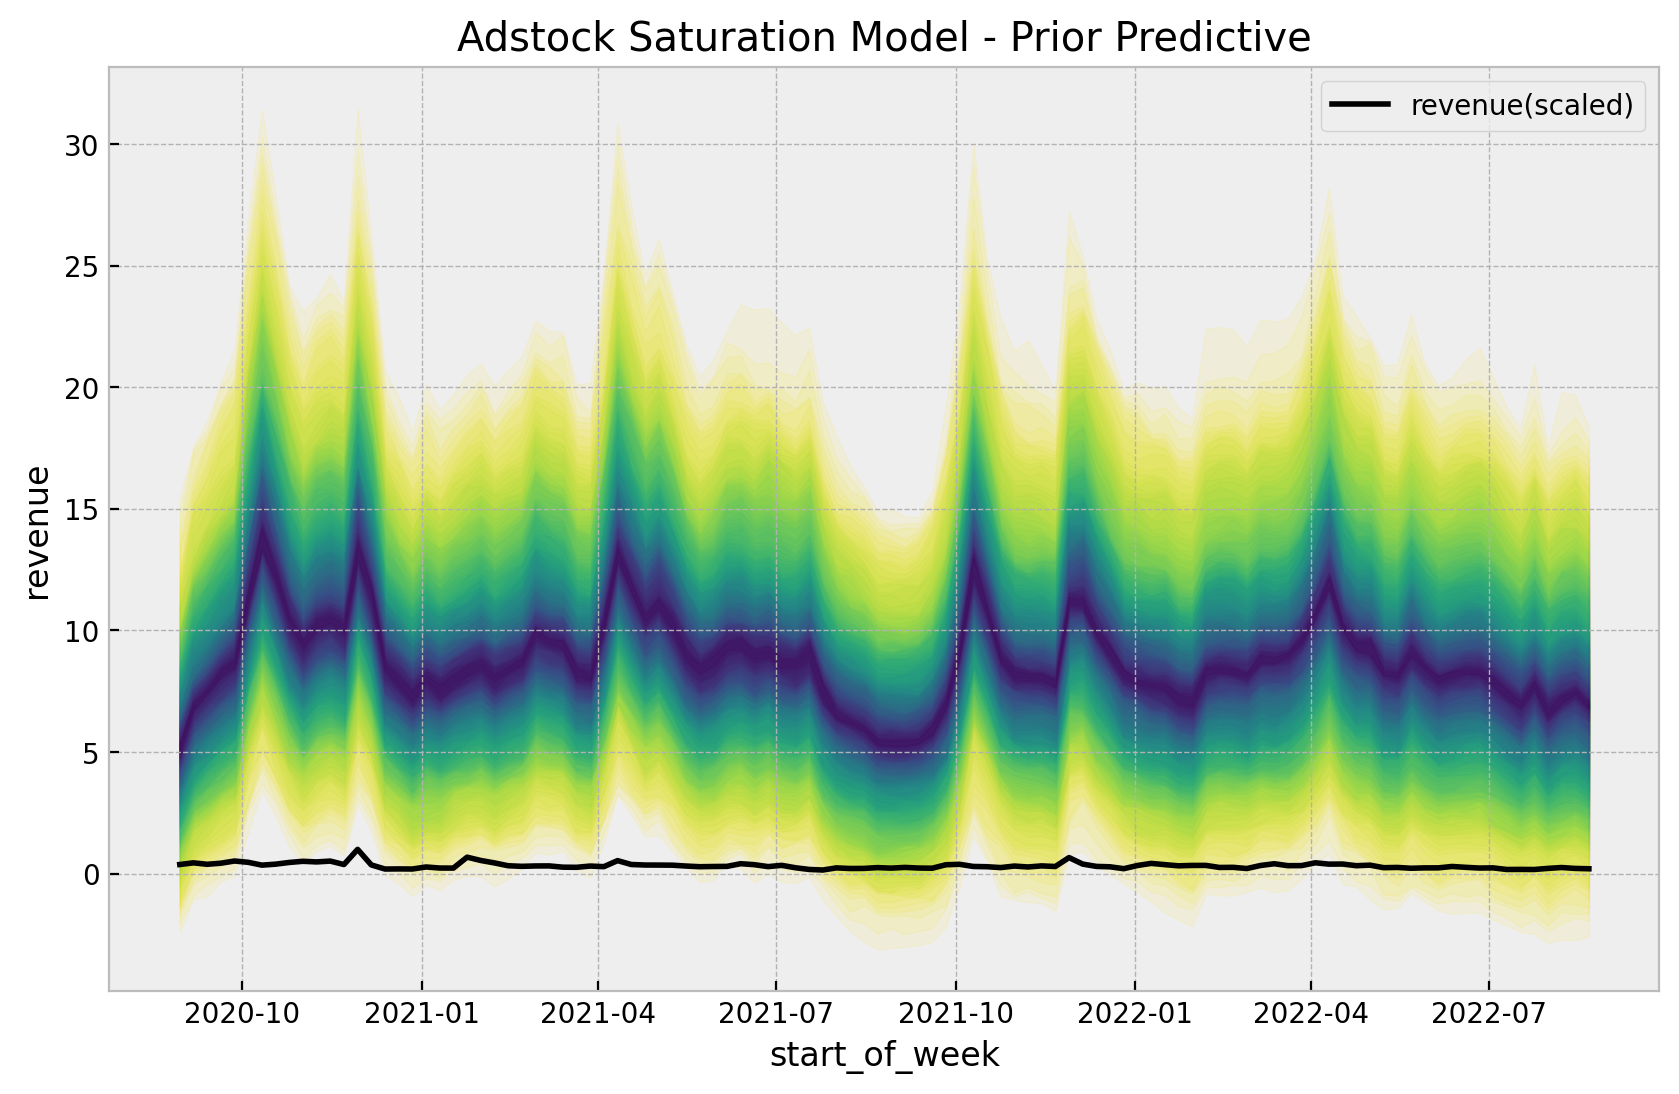

In [13]:
with adstock_saturation_model:
    adstock_saturation_model_prior_predictive = pm.sample_prior_predictive()


palette = "viridis_r"
cmap = plt.get_cmap(palette)
percs = np.linspace(51, 99, 100)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))

fig, ax = plt.subplots()

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(
        adstock_saturation_model_prior_predictive.prior_predictive["revenue"],
        p,
        axis=1,
    )
    lower = np.percentile(
        adstock_saturation_model_prior_predictive.prior_predictive["revenue"], 100 - p, axis=1
    )
    color_val = colors[i]
    ax.fill_between(
        x=date,
        y1=upper.flatten(),
        y2=lower.flatten(),
        color=cmap(color_val),
        alpha=0.1,
    )

sns.lineplot(x=date, y=df_transformed['revenue'], color="black", label="revenue(scaled)", ax=ax)
# sns.lineplot(x=date, y=y_scaled, color="black", label="target (scaled)", ax=ax)

ax.legend()
ax.set(title="Adstock Saturation Model - Prior Predictive");


In the "Adstock Saturation Model - Prior Predictive" plot the shaded area shows the prior predictive distribution. Namely, values of revenue given only prior information (no actual data has been given to model). The darker, the more probable.

The dark line is actual revenue (scaled).

In general we can say that the prior parameters need to be modified, such that the darker line stays inside the shaded area.

## sample_posterior_predictive

In [14]:
with adstock_saturation_model:
    adstock_saturation_model_trace = pm.sample(
        nuts_sampler="numpyro",
        draws=500,
        chains=2,
        idata_kwargs={"log_likelihood": True},
    )
    adstock_saturation_model_posterior_predictive = pm.sample_posterior_predictive(
        trace=adstock_saturation_model_trace,
    )


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

/usr/local/lib/python3.10/dist-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (25), generating only 20 plots
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


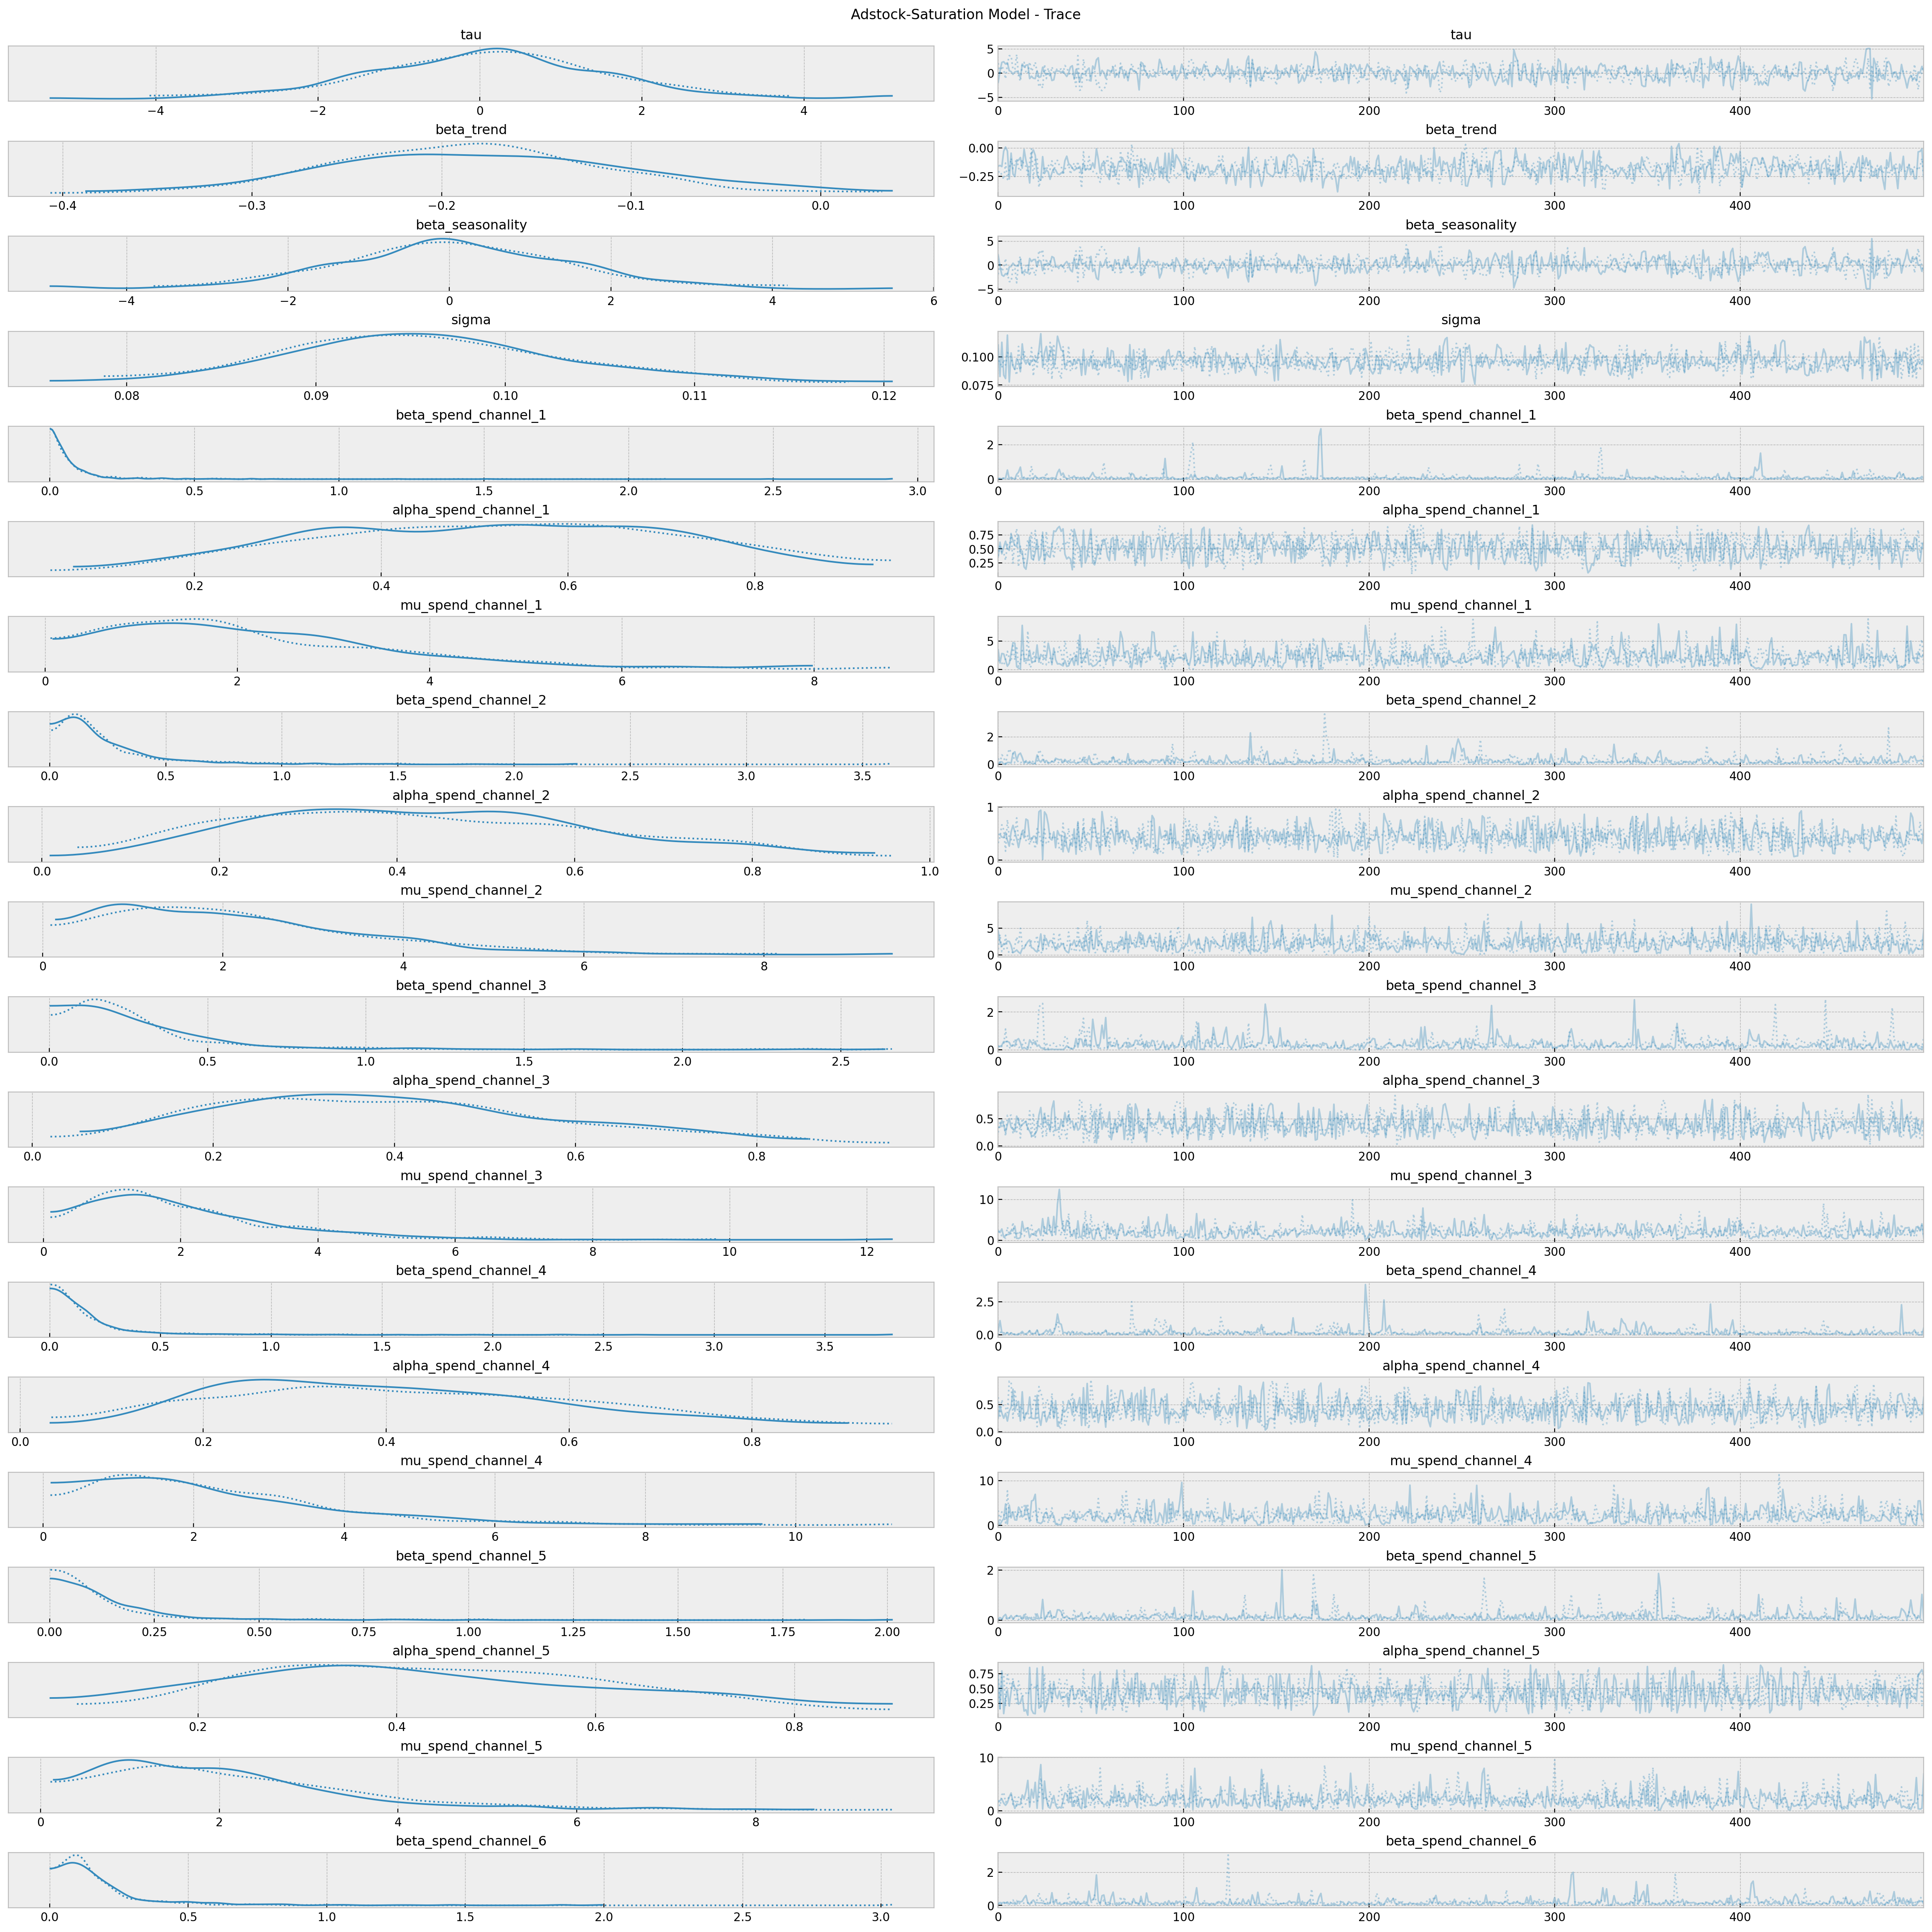

In [16]:
axes = az.plot_trace(
    data=adstock_saturation_model_trace,
    # var_names=["alpha_spend_channel_7", "beta_spend_channel_7", "mu_spend_channel_7"],
    compact=True,
    backend_kwargs={
        "figsize": (23, 23),
        "layout": "constrained"
    },
)
fig = axes[0][0].get_figure()
fig.suptitle("Adstock-Saturation Model - Trace");

The homogeneity of the trace plots on the right are also a good sign; there is no trend or pattern to the time series of sampled values. Note that we have some parameters such as beta_spend_channel_1, beta_spend_channel_2,...beta_spend_channel_7 occasionally sample extreme values, but this is expected from heavy-tailed distributions.

## The Energy Plot


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


<Axes: >

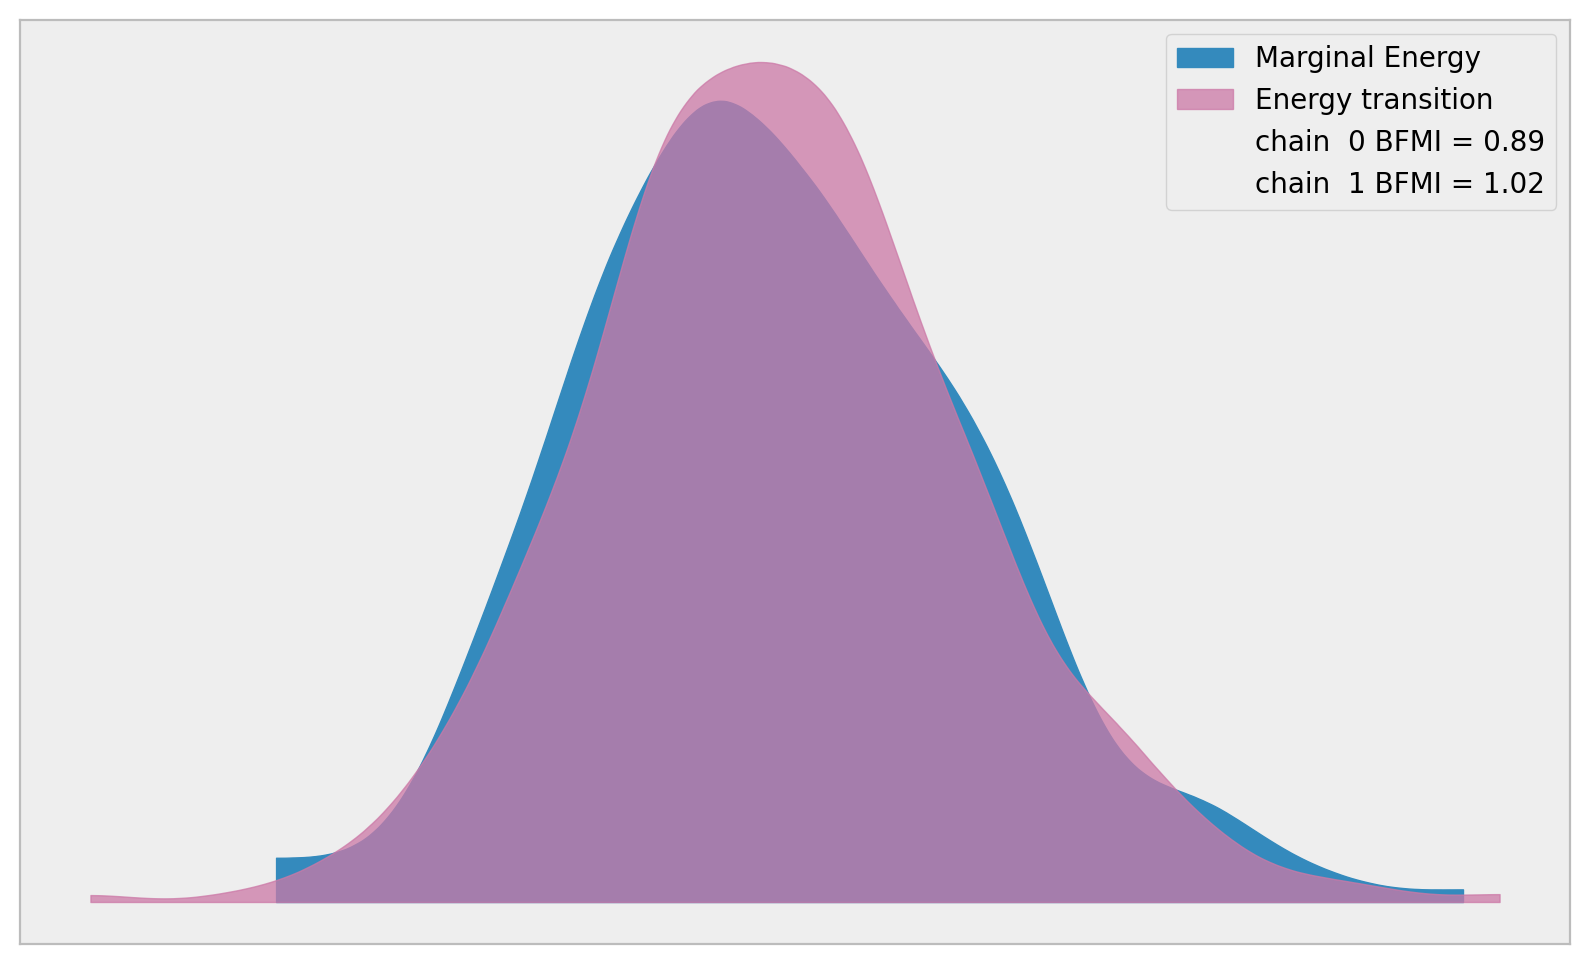

In [17]:
az.plot_energy(adstock_saturation_model_trace)

The preferable model is when these two distribution become more similar to each other. Here we can see some changes in parameters allocation are needed.


array([<Axes: title={'center': '94.0% HDI'}>,
       <Axes: title={'center': 'r_hat'}>], dtype=object)

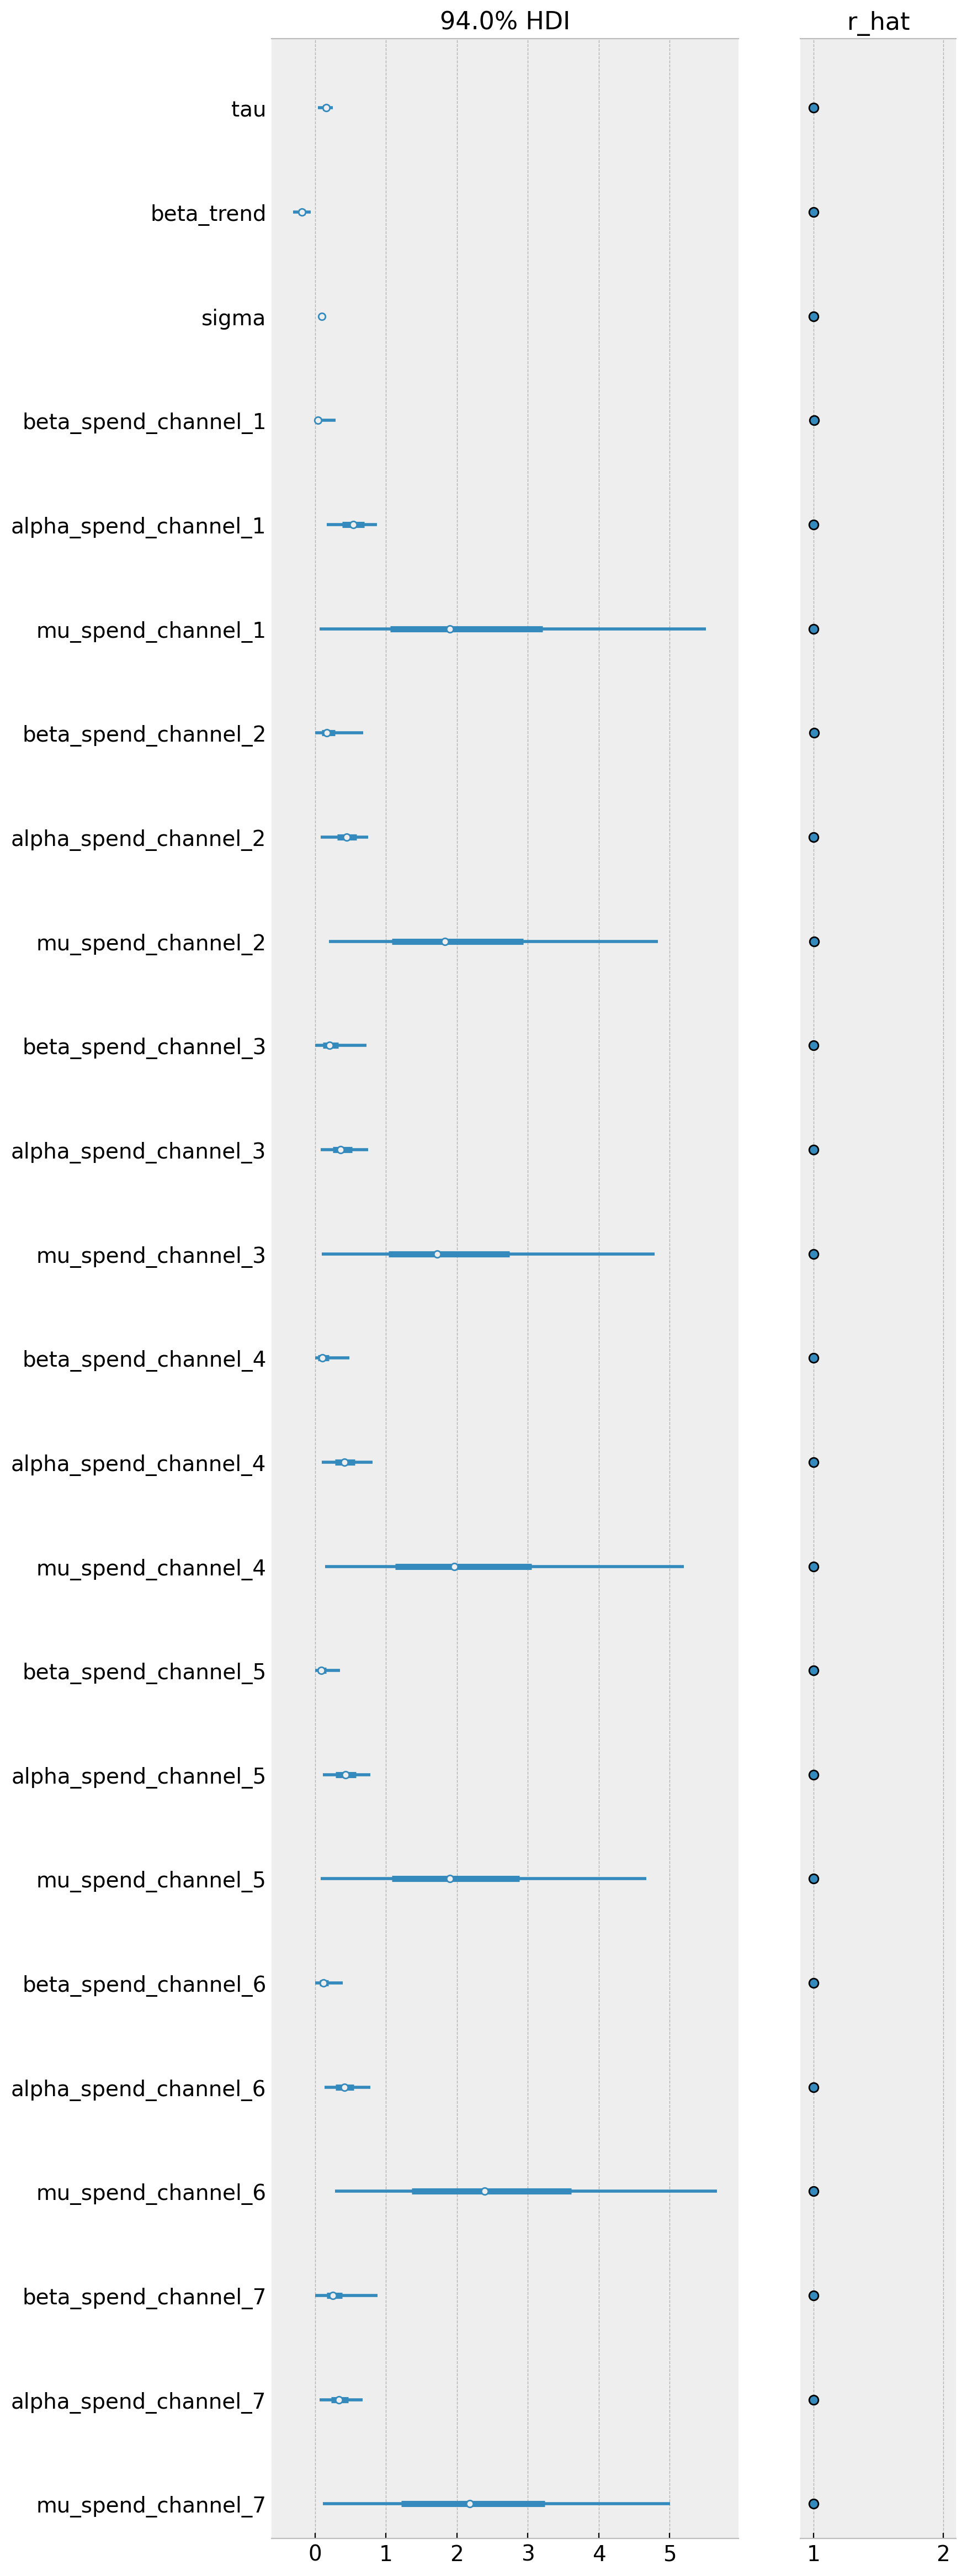

In [39]:
az.plot_forest(
    data=adstock_saturation_model_trace,
    # var_names=["beta_trend"],
    combined=True,
    hdi_prob=0.94,
    # ax=ax,
    r_hat=True
)


This plot shows for posteriors the probable range of parameters. This helps to modify the prior distribution's parameters. Trend has a negative effect. We also can say that apart from channel 7 that has slightly higher than the rest, others have a same effects.

## Posterior predictive checks (PPCs) for measuring model performance




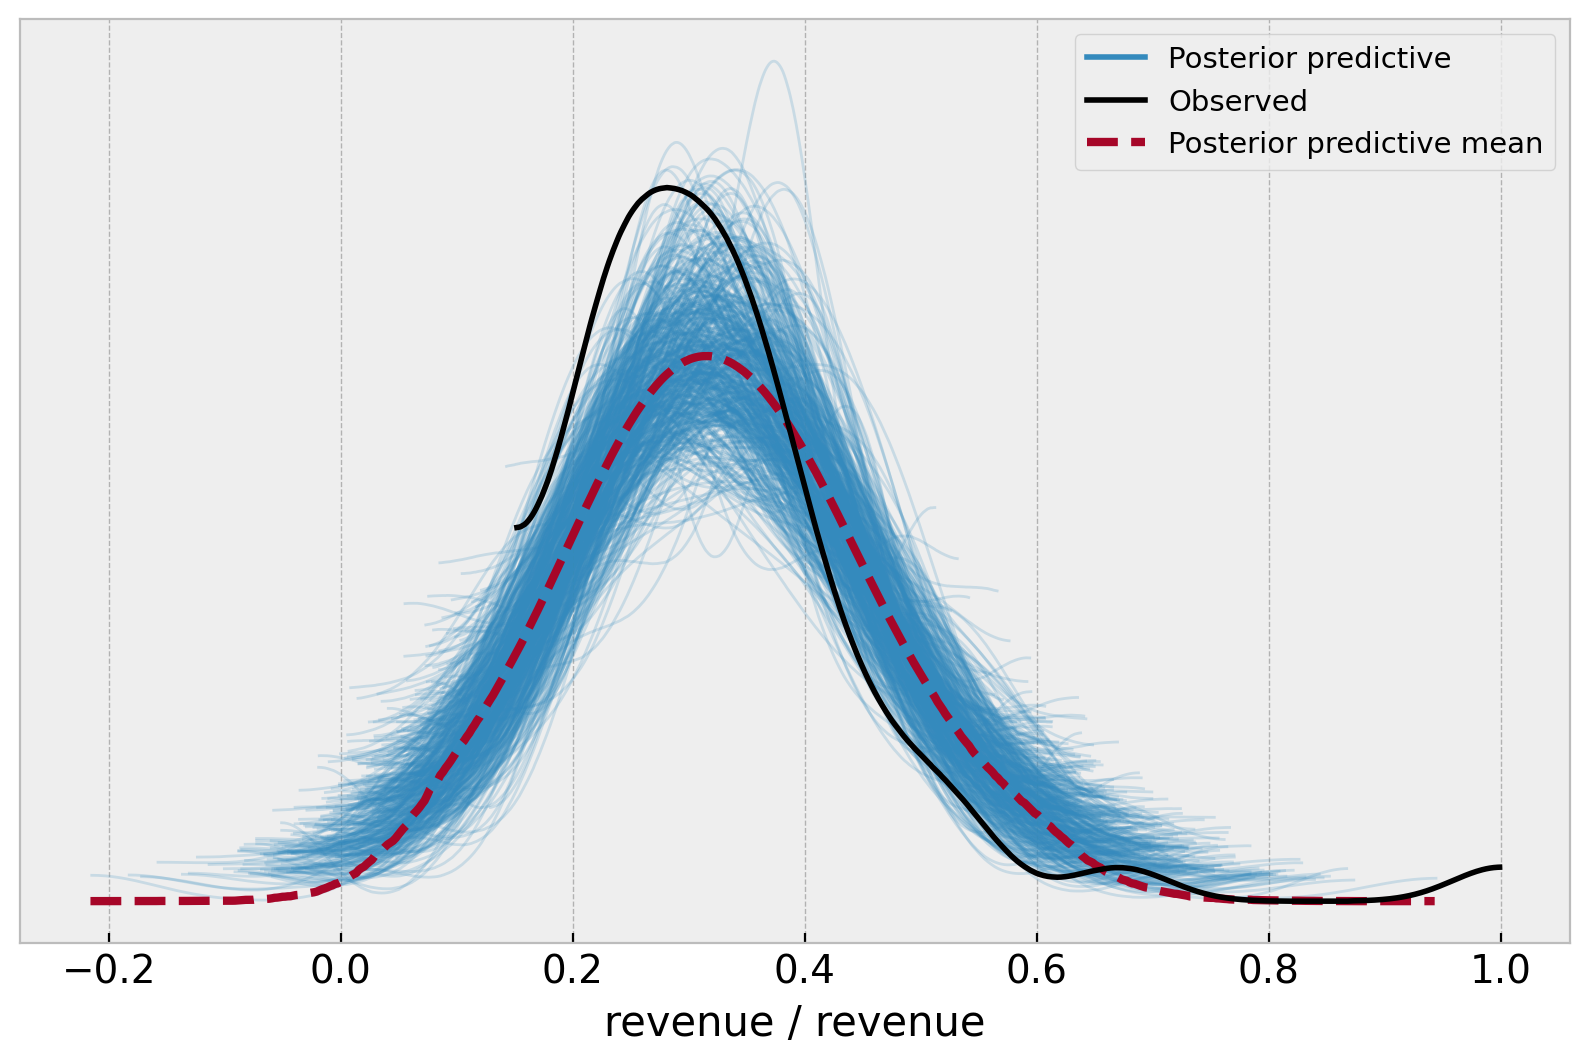

In [18]:

az.plot_ppc(adstock_saturation_model_posterior_predictive, num_pp_samples=500);


We can see the posterior predictives have overlapping with the observed data mostly. It seems kind of not very bad model.

## Model Diagnostics


In [19]:
az.summary(
    data=adstock_saturation_model_trace,
)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
tau                    0.091  1.442  -2.557    2.929      0.053    0.052   
beta_trend            -0.182  0.076  -0.316   -0.024      0.003    0.002   
beta_seasonality       0.054  1.442  -2.747    2.689      0.054    0.052   
sigma                  0.096  0.008   0.084    0.113      0.000    0.000   
beta_spend_channel_1   0.094  0.207   0.000    0.303      0.009    0.006   
alpha_spend_channel_1  0.522  0.193   0.188    0.868      0.006    0.004   
mu_spend_channel_1     2.223  1.543   0.077    4.985      0.046    0.033   
beta_spend_channel_2   0.245  0.288   0.001    0.684      0.012    0.008   
alpha_spend_channel_2  0.434  0.197   0.111    0.801      0.005    0.004   
mu_spend_channel_2     2.167  1.414   0.139    4.727      0.039    0.028   
beta_spend_channel_3   0.288  0.320   0.001    0.743      0.014    0.010   
alpha_spend_channel_3  0.396  0.184   0.100    0.753      0.005    0.004   
mu_spend_channel_3     2.022  1.426   0.157    4.573      0.049    0.040   
beta_spend_channel_4   0.186  0.291   0.000    0.562      0.013    0.009   
alpha_spend_channel_4  0.421  0.198   0.116    0.824      0.005    0.004   
mu_spend_channel_4     2.260  1.634   0.100    5.180      0.051    0.037   
beta_spend_channel_5   0.143  0.202   0.000    0.417      0.007    0.005   
alpha_spend_channel_5  0.436  0.190   0.091    0.762      0.005    0.004   
mu_spend_channel_5     2.154  1.507   0.102    4.905      0.043    0.034   
beta_spend_channel_6   0.182  0.228   0.000    0.506      0.009    0.006   
alpha_spend_channel_6  0.416  0.181   0.085    0.740      0.005    0.004   
mu_spend_channel_6     2.688  1.735   0.201    5.929      0.050    0.035   
beta_spend_channel_7   0.352  0.476   0.001    0.865      0.025    0.018   
alpha_spend_channel_7  0.384  0.198   0.073    0.746      0.006    0.005   
mu_spend_channel_7     2.445  1.596   0.109    5.339      0.043    0.030   

                       ess_bulk  ess_tail  r_hat  
tau                       733.0     551.0   1.02  
beta_trend                798.0     436.0   1.01  
beta_seasonality          729.0     549.0   1.01  
sigma                    1244.0     542.0   1.00  
beta_spend_channel_1      844.0     643.0   1.00  
alpha_spend_channel_1     934.0     670.0   1.00  
mu_spend_channel_1        964.0     627.0   1.00  
beta_spend_channel_2      606.0     581.0   1.00  
alpha_spend_channel_2    1440.0     682.0   1.00  
mu_spend_channel_2       1011.0     653.0   1.00  
beta_spend_channel_3      374.0     272.0   1.00  
alpha_spend_channel_3    1408.0     773.0   1.00  
mu_spend_channel_3        794.0     583.0   1.00  
beta_spend_channel_4      489.0     500.0   1.00  
alpha_spend_channel_4    1305.0     702.0   1.00  
mu_spend_channel_4        644.0     460.0   1.00  
beta_spend_channel_5      822.0     504.0   1.00  
alpha_spend_channel_5    1362.0     556.0   1.00  
mu_spend_channel_5       1121.0     615.0   1.00  
beta_spend_channel_6      567.0     461.0   1.00  
alpha_spend_channel_6    1213.0     538.0   1.01  
mu_spend_channel_6        954.0     683.0   1.00  
beta_spend_channel_7      588.0     394.0   1.00  
alpha_spend_channel_7    1370.0     668.0   1.00  
mu_spend_channel_7        862.0     444.0   1.00

The r_hat statitic for all parameters looks fine.

[Text(0.5, 1.0, 'Adstock-Saturation Model - Posterior Predictive Samples')]

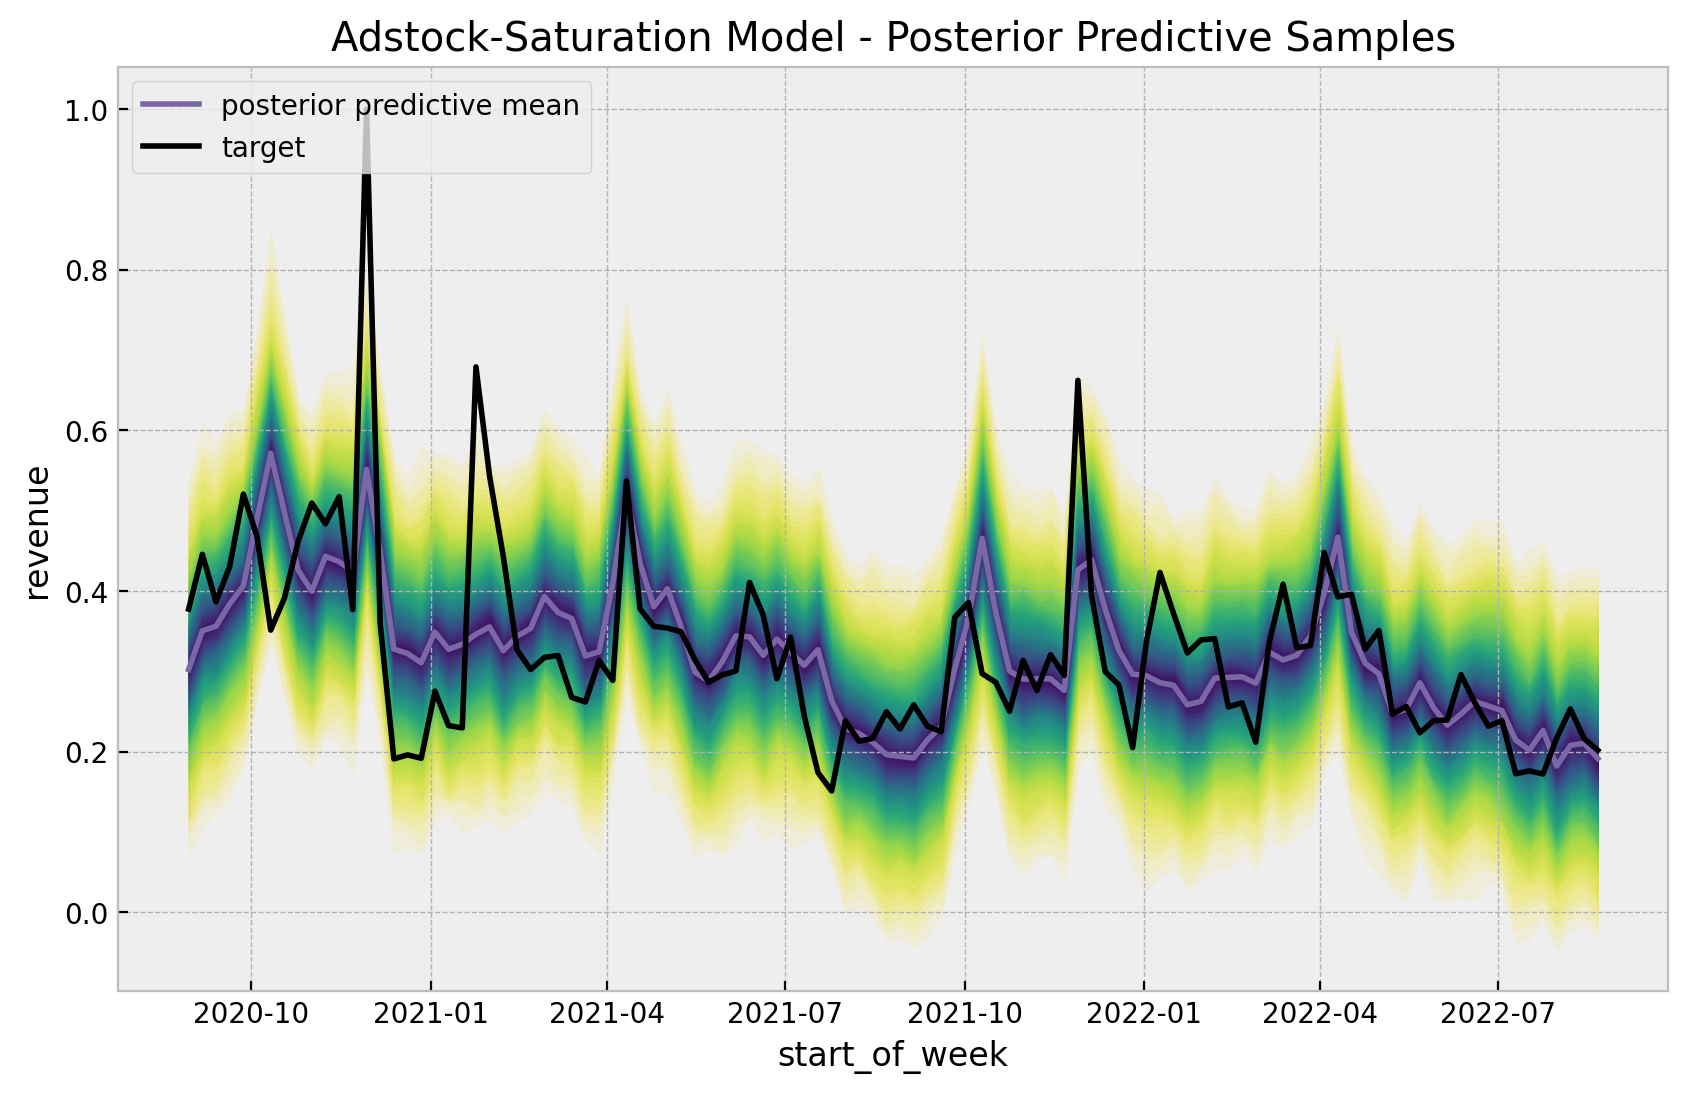

In [20]:
posterior_predictive_likelihood = az.extract(
    data=adstock_saturation_model_posterior_predictive,
    group="posterior_predictive",
    var_names="revenue",
)

# posterior_predictive_likelihood_inv = endog_scaler.inverse_transform(
#     X=posterior_predictive_likelihood
# )

fig, ax = plt.subplots()

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(posterior_predictive_likelihood, p, axis=1)
    lower = np.percentile(posterior_predictive_likelihood, 100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(
        x=date,
        y1=upper,
        y2=lower,
        color=cmap(color_val),
        alpha=0.1,
    )

sns.lineplot(
    x=date,
    y=posterior_predictive_likelihood.mean(axis=1),
    color="C2",
    label="posterior predictive mean",
    ax=ax,
)
sns.lineplot(
    x=date,
    y= df_transformed['revenue'],
    color="black",
    label="target",
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="Adstock-Saturation Model - Posterior Predictive Samples")

Plot show that sunstantial portion of shaded area has coverd the traget (revenue). However, the uncertainty is a little high. We need to adjust the prior parameters.

## MSE

In [21]:
predicted_revenue = adstock_saturation_model_posterior_predictive.posterior_predictive['revenue']
actual_revenue = df_transformed["revenue"].values

mse_values = []
for chain_idx in range(predicted_revenue.shape[0]):  # Loop through chains
  for draw_idx in range(predicted_revenue.shape[1]):  # Loop through draws within chain
    predicted_sample = predicted_revenue[chain_idx, draw_idx].values
    mse_values.append(mean_squared_error(actual_revenue, predicted_sample))
np.mean(mse_values)

0.018305697155875492

The value of MSE seems promesing since it close to zero

In [201]:
with adstock_saturation_model:
      trace__ = pm.sample(1000)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553 in run_code        │
│                                                                                                  │
│   3550 │   │   │   │   elif async_ :                                                             │
│   3551 │   │   │   │   │   await eval(code_obj, self.user_global_ns, self.user_ns)               │
│   3552 │   │   │   │   else:                                                                     │
│ ❱ 3553 │   │   │   │   │   exec(code_obj, self.user_global_ns, self.user_ns)                     │
│   3554 │   │   │   finally:                                                                      │
│   3555 │   │   │   │   # Reset our crash handler in place                                        │
│   3556 │   │   │   │   sys.excepthook = old_excepthook                                           │
│ in <cell line: 1>:2                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/pymc/sampling/mcmc.py:641 in sample                      │
│                                                                                                  │
│    638 │                                                                                         │
│    639 │   model = modelcontext(model)                                                           │
│    640 │   if not model.free_RVs:                                                                │
│ ❱  641 │   │   raise SamplingError(                                                              │
│    642 │   │   │   "Cannot sample from the model, since the model does not contain any free var  │
│    643 │   │   )                                                                                 │
│    644                                                                                           │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
SamplingError: Cannot sample from the model, since the model does not contain any free variables.